In [1]:
%matplotlib inline
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

np.random.seed(1234)

# Understanding Probabilistic Topic Models By Simulation

* Tim Hopper
* [@tdhopper](https://twitter.com/tdhopper)
* Data Science at [Distil Networks](distilnetworks.com)

Slides available at https://github.com/tdhopper/pydata-nyc-2015

# What is Latent Dirichlet Allocation?

> LDA is a three-level hierarchical Bayesian model, in which each
item of a collection is modeled as a finite mixture over an underlying set of topics. 

> Each topic is, in turn, modeled as an infinite mixture over an underlying set of topic probabilities.

Duh.

[[source](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf)]

# What is Latent Dirichlet Allocation?

![](./static/graphical_model.png)

Duh.

# What is Latent Dirichlet Allocation?

$$
p(D \,|\, \alpha, \beta) =
\prod_{d=1}^M \int p(\theta_d \,|\, \alpha 
\left(
\prod_{n=1}^{N_d}
\sum_{z_{dn}}
p(z_{dn} \,|\, \theta_d)
p(w_dn \,|\, z_dn, \beta)
\right)
d \theta_d
$$

Duh.

![](./static/sheldon.gif)

# Gaussian Mixture Models

# Mixture Model for Documents

In [56]:
vocabulary = ['🐍', '🐼', '📊']
boring_vocabulary = [':snake:', ':panda_face:', ':computer:']
num_terms = len(vocabulary)

# Topics are distributions over vocabulary words
topic_labels = ['☀', '☁']
boring_topics = [':sunny:', ':cloud:']
topics = [[ 0.1,  0.3,  0.6],
          [ 0.8,  0.1,  0.1]]

# Proportion of documents of each topic
mixture_proportion = [0.3, 0.7]

num_docs = 5
mean_doc_length = 10

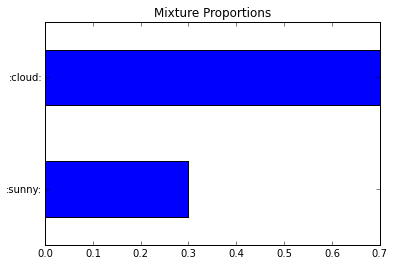

In [60]:
pd.Series(mixture_proportion, index=boring_topics).plot(kind='barh')
_=plt.title("Mixture Proportions")

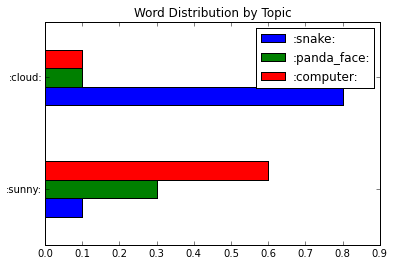

In [59]:
pd.DataFrame(topics, columns=boring_vocabulary, index=boring_topics).plot(kind='barh')
_=plt.title("Word Distribution by Topic")

    ➡ Forward Sampling
    
Let's generate some documents!

In [63]:
for doc_index in range(1, num_docs+1):
    topic = np.random.choice(topic_labels, p=mixture_proportion)
    doc_len = stats.poisson(mean_doc_length).rvs(1)
    doc = [np.random.choice(vocabulary, p=topics[topic_labels.index(topic)]) 
           for _ in range(doc_len)]
    print("Doc {:1d} (topic {}): {}".format(doc_index, topic, ''.join(doc)))

Doc 1 (topic ☁): 🐼📊🐼🐼🐼🐍🐼🐍📊🐍🐍🐍🐍🐍
Doc 2 (topic ☁): 🐍🐍🐍🐍📊
Doc 3 (topic ☁): 📊🐍🐍🐍🐍🐍🐍🐍🐍
Doc 4 (topic ☁): 🐼🐍🐍
Doc 5 (topic ☁): 🐍🐼🐍🐍🐍🐍🐍🐍🐍


    """
    ⬅ Reversing the Process
    """

Given a collection of documents...

...find the distribution over topics

...find the distribution over terms for each topic

    """
    ⬅ Limitations of this Model
    """
    
* Word order irrelevant. (Bag-of-words assumption!)
    * Ignores all linguistic structure!
* Single topic per document.